In [1]:
#data related imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler

# classification model imports
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# deep learning model imports
from keras.callbacks import EarlyStopping
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D, Flatten, Dense, Dropout, GRU, LeakyReLU, ReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.regularizers import l2


#visualizations
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # <-- needed for 3D plotting
from matplotlib.cm import viridis

import time

import joblib



In [ ]:
df = pd.read_csv('E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv', low_memory=False)

In [ ]:
print(df.isnull().sum())

In [ ]:
print(df.duplicated().sum())

In [ ]:
#because it takes a lot of time to train the svm on the wholedataset. on internet, it was recommended to train it on a shorter dataset and then test it.

df = df.sample(frac=0.35, random_state=42)  # random_state for reproducibility

In [ ]:
# Drop rows with missing values
df.dropna(inplace=True)
method_encoder = LabelEncoder()


# Fit and transform
df['http.request.method_encoded'] = method_encoder.fit_transform(df['http.request.method'].astype(str))
df['http.request.version_encoded'] = np.where(df['http.request.version'].astype(str).str.strip() == '0', 0, 1)
df['mqtt_topic'] = method_encoder.fit_transform(df['mqtt.topic'].astype(str))
df['mqtt_protoname'] = method_encoder.fit_transform(df['mqtt.protoname'].astype(str))
df['Attack_type'] = np.where(df['Attack_type'].astype(str).str.strip() == 'normal', 0, 1)

# Step 1: Drop object columns
X = df.drop(columns=[
    'Attack_label','http.request.full_uri', 'http.referer', 'http.file_data', 
    'tcp.payload', 'frame.time', 'mqtt.msg', 'tcp.options', 'dns.qry.name', 
    'http.request.method', 'http.request.version', 'mqtt.topic', 'mqtt.protoname','ip.src_host',
    'ip.dst_host','arp.dst.proto_ipv4','arp.src.proto_ipv4','http.request.uri.query','tcp.srcport',
    'dns.qry.name.len','mqtt.conack.flags'
])

# Step 2: Set target
y = df['Attack_label']

# Train-val-test split: 70/20/10

# First split: Train 70%, Temp 30%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Second split: Validation 20% (2/3 of 30%), Test 10% (1/3 of 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42
)

# Reset indices to avoid any overlap when converting to NumPy later
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [ ]:
print("Train class distribution:\n", y_train.value_counts())
print("Validation class distribution:\n", y_val.value_counts())
print("Test class distribution:\n", y_test.value_counts())

In [ ]:
X.info()

# Support Vector Machine

In [ ]:
# Train the SVM model
start_time_svm = time.time()

svm = LinearSVC( max_iter=1000, C=1.0, verbose=True)
svm.fit(X_train, y_train)

end_time_svm = time.time()

training_duration_svm = end_time_svm - start_time_svm


joblib.dump(svm, 'svm_model.joblib')

In [ ]:
# Predict
y_pred = svm.predict(X_test)

In [ ]:
# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print(f"training duration: {training_duration_svm}")

In [ ]:
pca = PCA(n_components=3)
X_test_pca = pca.fit_transform(X_test)



In [ ]:

cmap = plt.cm.viridis

true_colors = np.array([cmap(float(c)) for c in y_test])
pred_colors = np.array([cmap(float(c)) for c in y_pred])

wrong_mask = (y_pred != y_test)
pred_colors[wrong_mask] = np.array([1, 0, 0, 1])  # red for wrong preds


In [ ]:
# Plot side by side
fig = plt.figure(figsize=(16,7))

# True labels plot
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=true_colors, alpha=0.8)
ax1.set_title("True Labels (Viridis)")
ax1.set_xlabel("PCA 1")
ax1.set_ylabel("PCA 2")
ax1.set_zlabel("PCA 3")

# Predicted labels plot with red wrong preds
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_test_pca[:, 0], X_test_pca[:, 1], X_test_pca[:, 2], c=pred_colors, alpha=0.8)
ax2.set_title("Predicted Labels (Viridis) with Wrong Predictions in Red")
ax2.set_xlabel("PCA 1")
ax2.set_ylabel("PCA 2")
ax2.set_zlabel("PCA 3")

plt.show()

# decision tree classifier

In [ ]:
print("Train class distribution:\n", y_train.value_counts())
print("Validation class distribution:\n", y_val.value_counts())
print("Test class distribution:\n", y_test.value_counts())

In [ ]:
print("X shape:", X.shape)
print("X columns:", X.columns.tolist())

In [ ]:



model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,       # Disable the label encoder warning
    objective='binary:logistic',   # Important: binary classification objective
    eval_metric='logloss'          # Evaluation metric
)

# Start timer
start_time = time.time()

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=True  # Optional: shows training log
)

# End timer
end_time = time.time()

model.save_model("xgb_model.json")

# upload_file(
#     path_or_fileobj="xgb_model.json",  # or "xgb_model.pkl"
#     path_in_repo="xgb_model.json",     # File name in the repo
#     repo_id="ScHemer34/DT_XGBoost",
#     repo_type="model"
# )


In [ ]:
y_pred = model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['normal', 'attack']))

# Print duration
training_duration = end_time - start_time
print(f"\n✅ Model trained in {training_duration:.2f} seconds")

# Dataset for Deep Learning Models

In [2]:
df_fnn = pd.read_csv("E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv")  # adjust path


C:\Users\afnan\AppData\Local\Temp\ipykernel_9736\2820990379.py:1: DtypeWarning: Columns (2,3,6,11,13,14,15,16,17,31,32,34,39,45,51,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fnn = pd.read_csv("E:/masters material/thesis/datasets/Edge-IIoTset dataset/Selected dataset for ML and DL/DNN-EdgeIIoT-dataset.csv")  # adjust path


In [3]:
df_fnn.isnull().sum()

frame.time            0
ip.src_host           0
ip.dst_host           0
arp.dst.proto_ipv4    0
arp.opcode            0
                     ..
mbtcp.len             0
mbtcp.trans_id        0
mbtcp.unit_id         0
Attack_label          0
Attack_type           0
Length: 63, dtype: int64

In [4]:
    # Drop rows with missing values
    # df_fnn.dropna(inplace=True)

    #encoding important columns
    # Initialize encoder
    method_encoder = LabelEncoder()

    # Fit and transform
    df_fnn['http.request.method_encoded'] = method_encoder.fit_transform(df_fnn['http.request.method'].astype(str))
    df_fnn['http.request.version_encoded'] = np.where(df_fnn['http.request.version'].astype(str).str.strip() == '0', 0, 1)
    df_fnn['mqtt_topic'] = method_encoder.fit_transform(df_fnn['mqtt.topic'].astype(str))
    df_fnn['mqtt_protoname'] = method_encoder.fit_transform(df_fnn['mqtt.protoname'].astype(str))
    df_fnn['Attack_label'] = np.where(df_fnn['Attack_label'].astype(str).str.strip() == 'normal', 0, 1)
    df_fnn['Attack_type_encoded'] = method_encoder.fit_transform(df_fnn['Attack_type'].astype(str))

    # Step 2: Set target
    y_fnn = df_fnn['Attack_type_encoded']

    # Now drop object and unnecessary columns
    X_fnn = df_fnn.drop(columns=[
        'Attack_type', 'Attack_type_encoded', 'Attack_label', 'http.request.full_uri', 'http.referer', 'http.file_data', 
        'tcp.payload', 'frame.time', 'mqtt.msg', 'tcp.options', 'dns.qry.name', 
        'http.request.method', 'http.request.version', 'mqtt.topic', 'mqtt.protoname','ip.src_host',
        'ip.dst_host','arp.dst.proto_ipv4','arp.src.proto_ipv4','http.request.uri.query','tcp.srcport',
        'dns.qry.name.len','mqtt.conack.flags'
    ])

In [5]:

# First split: Train 80%, Temp 20%
X_train_fnn, X_temp_fnn, y_train_fnn, y_temp_fnn = train_test_split(
    X_fnn, y_fnn, test_size=0.2, stratify=y_fnn, random_state=42
)

# Second split: Validation 10% (1/2 of 20%), Test 10% (1/2 of 20%)
X_val_fnn, X_test_fnn, y_val_fnn, y_test_fnn = train_test_split(
    X_temp_fnn, y_temp_fnn, test_size=1/2, stratify=y_temp_fnn, random_state=42
)

# Reset indices to avoid any overlap when converting to NumPy later
X_train_fnn = X_train_fnn.reset_index(drop=True)
X_val_fnn = X_val_fnn.reset_index(drop=True)
X_test_fnn = X_test_fnn.reset_index(drop=True)

y_train_fnn = y_train_fnn.reset_index(drop=True)
y_val_fnn = y_val_fnn.reset_index(drop=True)
y_test_fnn = y_test_fnn.reset_index(drop=True)


In [6]:
overlap = set(map(tuple, X_train_fnn.values)) & set(map(tuple, X_val_fnn.values))
print(f"Train/Val Overlap: {len(overlap)}")  # Should be 0

Train/Val Overlap: 39682


In [7]:
print("Train class distribution:\n", y_train_fnn.value_counts())
print("Validation class distribution:\n", y_val_fnn.value_counts())
print("Test class distribution:\n", y_test_fnn.value_counts())

Train class distribution:
 Attack_type_encoded
7     1292514
4       97254
2       93149
11      40962
8       40122
13      40088
3       40050
1       39929
12      30107
0       19890
9       18051
14      12732
10       8740
6         971
5         801
Name: count, dtype: int64
Validation class distribution:
 Attack_type_encoded
7     161564
4      12157
2      11643
11      5120
8       5015
13      5011
3       5006
1       4991
12      3763
0       2486
9       2257
14      1592
10      1093
6        122
5        100
Name: count, dtype: int64
Test class distribution:
 Attack_type_encoded
7     161565
4      12157
2      11644
11      5121
8       5016
13      5011
3       5006
1       4991
12      3764
0       2486
9       2256
14      1591
10      1092
6        121
5        100
Name: count, dtype: int64


In [8]:
df_fnn['Attack_type_encoded'].value_counts()

Attack_type_encoded
7     1615643
4      121568
2      116436
11      51203
8       50153
13      50110
3       50062
1       49911
12      37634
0       24862
9       22564
14      15915
10      10925
6        1214
5        1001
Name: count, dtype: int64

In [9]:
print(df_fnn[['Attack_label']].head(10))

   Attack_label
0             1
1             1
2             1
3             1
4             1
5             1
6             1
7             1
8             1
9             1


# Feed Forward Neural Network

In [ ]:
# Define the model
def build_fnn_model(input_size):
    model = Sequential()
    model.add(Dense(45, input_dim=input_size,name="Hidden_Layer_1", kernel_regularizer=l2(0.25)))  
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.1))
#     model.add(Dense(32, input_dim=input_size, kernel_regularizer=l2(0.001)))
#     model.add(LeakyReLU(alpha=0.01))
#     model.add(Dropout(0.2))
    model.add(Dense(16, input_dim=input_size,name="Hidden_Layer_2",kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.1))
    model.add(Dense(1,activation="sigmoid",name="Output_layer")) # No sigmoid here if using BCEWithLogitsLoss
    return model


In [ ]:
#normalize the data
scaler = StandardScaler()
X_train_fnn = scaler.fit_transform(X_train_fnn)
X_val_fnn = scaler.transform(X_val_fnn)
X_test_fnn = scaler.transform(X_test_fnn)


# convert dataframe to numpy arrays
y_train_tensor_fnn = y_train_fnn.to_numpy()

y_val_tensor_fnn = y_val_fnn.to_numpy()

y_test_tensor_fnn = y_test_fnn.to_numpy()



In [ ]:
model.summary()

In [ ]:
# Start timer
start_time_fnn = time.time()

# Build model
input_size = X_train_fnn.shape[1]
model = build_fnn_model(input_size)

# Compile with BCEWithLogitsLoss equivalent
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = Adam()
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])



history = model.fit(
    X_train_fnn, y_train_tensor_fnn,
    validation_data=(X_val_fnn, y_val_tensor_fnn),
    epochs=15,
    batch_size=32,
    shuffle=True,
    callbacks=None,
    class_weight=None,
    verbose=1
)


# End timer
end_time_fnn = time.time()



# Duration
training_duration_fnn = end_time_fnn - start_time_fnn
print(f"⏱️ Model trained in {training_duration_fnn:.2f} seconds")


In [ ]:
# Save the model
model.save("fnn_model_tf.h5")

In [ ]:
# Evaluate
loss, accuracy = model.evaluate(X_test_fnn, y_test_tensor_fnn, verbose=1)
print(f"\n🧪 Test Accuracy: {accuracy:.4f}")


In [ ]:
logits = model.predict(X_test_fnn)
preds = (logits > 0.5).astype(int).flatten()  
# Ground truth
y_true = y_test_tensor_fnn.flatten()

In [ ]:
# Get the raw model outputs (logits)
logits = model.predict(X_test_fnn)


# Convert probabilities to binary predictions
preds = (probs > 0.5).astype(int).flatten()

# Ground truth
y_true = y_test_tensor_fnn.flatten()

In [ ]:
cm = confusion_matrix(y_true, preds)
print("Confusion Matrix:")
print(cm)

In [ ]:
report = classification_report(y_true, preds, digits=4)
print("\nClassification Report:")
print(report)

# Convolutional Neural Network

In [ ]:
# Convert to numpy arrays
# X_train = X_train_fnn.to_numpy()
# X_val = X_val_fnn.to_numpy()
# X_test = X_test_fnn.to_numpy()

y_train = y_train_fnn.to_numpy()
y_val = y_val_fnn.to_numpy()
y_test = y_test_fnn.to_numpy()

In [ ]:
# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_cnn = X_train_fnn.reshape((X_train_fnn.shape[0], X_train_fnn.shape[1], 1))
X_val_cnn = X_val_fnn.reshape((X_val_fnn.shape[0], X_val_fnn.shape[1], 1))
X_test_cnn = X_test_fnn.reshape((X_test_fnn.shape[0], X_test_fnn.shape[1], 1))

In [ ]:
# Build CNN model
model = Sequential([
    Conv1D(45, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1),kernel_regularizer=l2(0.2)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu',kernel_regularizer=l2(0.05)),
    Dropout(0.2),
    Dense(1, activation='sigmoid',kernel_regularizer=l2(0.01))  # Use 1 and sigmoid for binary classification
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train model
start_time_cnn = time.time()

history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=15,
    batch_size=32,
    shuffle=True,
    callbacks=None,
    class_weight=None,
    verbose=1
)
end_time_cnn = time.time()

training_duration_cnn = end_time_cnn - start_time_cnn


In [ ]:
print(f"⏱️ Model trained in {training_duration_cnn:.2f} seconds")

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
# Predictions
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int)


In [ ]:
# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

In [ ]:
# Plot training/validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
import seaborn as sns
# Plot confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

In [ ]:
# Save the model to an HDF5 file
model.save("cnn_model.h5")

# Long Short Term Memory


In [10]:
timesteps = 1

num_features = X_train_fnn.shape[1]

# --- Step 1: Convert DataFrames to NumPy Arrays ---
X_train_fnn = X_train_fnn.to_numpy()
y_train_lstm = y_train_fnn.to_numpy().reshape(-1, 1)

X_val_fnn = X_val_fnn.to_numpy()
y_val_lstm = y_val_fnn.to_numpy().reshape(-1, 1)

X_test_fnn = X_test_fnn.to_numpy()  # Convert to numpy array
y_test_lstm = y_test_fnn.to_numpy().reshape(-1, 1)

# --- Step 2: Scale Features ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_fnn)
X_val_scaled = scaler.transform(X_val_fnn)  # use transform only on val
X_test_scaled = scaler.transform(X_test_fnn)  # use transform only on val



X_train_lstm = X_train_scaled.reshape(-1, timesteps, num_features)
X_val_lstm = X_val_scaled.reshape(-1, timesteps, num_features)
X_test_lstm = X_test_scaled.reshape(-1, timesteps, num_features)

y_train_lstm = to_categorical(y_train_fnn)
y_val_lstm = to_categorical(y_val_fnn)
y_test_lstm = to_categorical(y_test_fnn)

In [14]:
model = Sequential()
model.add(LSTM(units = 128, return_sequences = True , input_shape=(timesteps,num_features), activation='tanh'))
model.add(LSTM(units = 64, activation = 'tanh', return_sequences = True))
model.add(LSTM(units = 32, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

C:\Users\afnan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 128)              │          89,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 150,945 (589.63 KB)

 Trainable params: 150,945 (589.63 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
num_classes = y_train_lstm.shape[1]

# ---------- 2. Define LSTM model ----------
model = Sequential()
model.add(LSTM(45, return_sequences=True, activation='relu', input_shape=(timesteps, num_features))) 
model.add(Dropout(0.2))


model.add(Dense(16))
model.add(ReLU())

model.add(LSTM(8, return_sequences=False)) 
model.add(Dropout(0.2))

model.add(ReLU())


model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model.summary()

C:\Users\afnan\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 45)               │          16,380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 45)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1, 16)               │             736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │             135 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,051 (70.51 KB)

 Trainable params: 18,051 (70.51 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Step 5: Train
start_time_lstm = time.time()
history = model.fit(
    X_train_lstm, 
    y_train_lstm,                
    validation_data=(X_val_lstm, y_val_lstm), #validation dataset
    epochs=15,
    batch_size=32,
#     callbacks=None,
#     shuffle=True,
#     class_weight=None,
    verbose=1
)
end_time_lstm = time.time()
training_duration_lstm = end_time_lstm - start_time_lstm
print(f"training duration is: {training_duration_lstm}")

Epoch 1/15
55480/55480 ━━━━━━━━━━━━━━━━━━━━ 72s 1ms/step - accuracy: 0.8682 - loss: 0.4614 - val_accuracy: 0.9230 - val_loss: 0.2208
Epoch 2/15
55480/55480 ━━━━━━━━━━━━━━━━━━━━ 70s 1ms/step - accuracy: 0.8993 - loss: 0.2767 - val_accuracy: 0.9262 - val_loss: 0.2012
Epoch 3/15
55480/55480 ━━━━━━━━━━━━━━━━━━━━ 71s 1ms/step - accuracy: 0.9064 - loss: 0.2556 - val_accuracy: 0.9334 - val_loss: 0.1780
Epoch 4/15
55480/55480 ━━━━━━━━━━━━━━━━━━━━ 71s 1ms/step - accuracy: 0.9155 - loss: 0.2385 - val_accuracy: 0.9360 - val_loss: 0.1708
Epoch 5/15
55480/55480 ━━━━━━━━━━━━━━━━━━━━ 72s 1ms/step - accuracy: 0.9186 - loss: 0.2307 - val_accuracy: 0.9372 - val_loss: 0.1673
Epoch 6/15
55480/55480 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step - accuracy: 0.9204 - loss: 0.2251 - val_accuracy: 0.9370 - val_loss: 0.1653
Epoch 7/15
55480/55480 ━━━━━━━━━━━━━━━━━━━━ 71s 1ms/step - accuracy: 0.9224 - loss: 0.2215 - val_accuracy: 0.9374 - val_loss: 0.1626
Epoch 8/15
55480/55480 ━━━━━━━━━━━━━━━━━━━━ 72s 1ms/step - accuracy: 

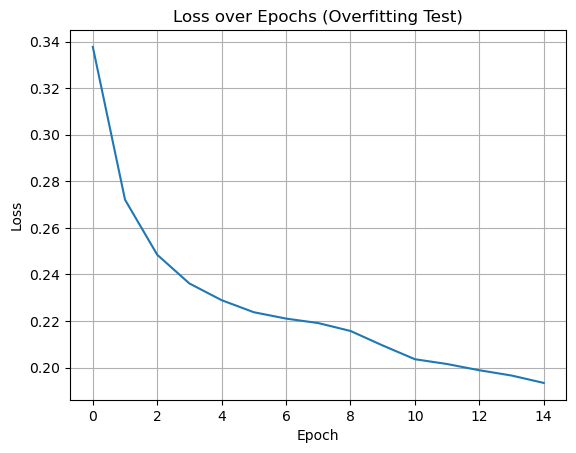

In [13]:
# ---------- 4. Check loss over time ----------

plt.plot(history.history['loss'])
plt.title('Loss over Epochs (Overfitting Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
print("x_test_fnn shape:", X_test_fnn.shape)
print("timesteps:", timesteps)
print("num_features:", num_features)

In [ ]:
X_test_array = X_test_fnn.to_numpy()  # Convert to numpy array
y_test_np = y_test_fnn.to_numpy().reshape(-1, 1)

# Check shape of X_test_array
print("X_test_array shape:", X_test_array.shape)

# Reshape to (samples, timesteps, num_features)
X_test_lstm = X_test_array.reshape((X_test_array.shape[0], timesteps, num_features))
print("X_test_lstm shape:", X_test_lstm.shape)

In [18]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict class probabilities
y_pred_prob = model.predict(X_test_lstm)

# Get predicted classes (argmax of softmax output)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true classes (from one-hot encoded labels)
y_true = np.argmax(y_test_lstm, axis=1)



6936/6936 ━━━━━━━━━━━━━━━━━━━━ 6s 913us/step - accuracy: 0.9429 - loss: 0.1396
Test Loss: 0.1417
Test Accuracy: 0.9417
6936/6936 ━━━━━━━━━━━━━━━━━━━━ 6s 800us/step


In [15]:

# Print classification report

print(classification_report(y_test_lstm, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      2486
           1       0.96      0.59      0.73      4991
           2       1.00      1.00      1.00     11644
           3       0.70      1.00      0.83      5006
           4       1.00      1.00      1.00     12157
           5       0.85      0.11      0.19       100
           6       1.00      0.94      0.97       121
           7       1.00      1.00      1.00    161565
           8       0.00      0.00      0.00      5016
           9       0.67      0.08      0.15      2256
          10       0.89      0.06      0.11      1092
          11       0.71      0.44      0.54      5121
          12       0.94      0.37      0.53      3764
          13       0.87      0.84      0.85      5011
          14       1.00      0.02      0.04      1591

   micro avg       0.98      0.92      0.95    221921
   macro avg       0.83      0.56      0.59    221921
weighted avg       0.95   

C:\Users\afnan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\afnan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

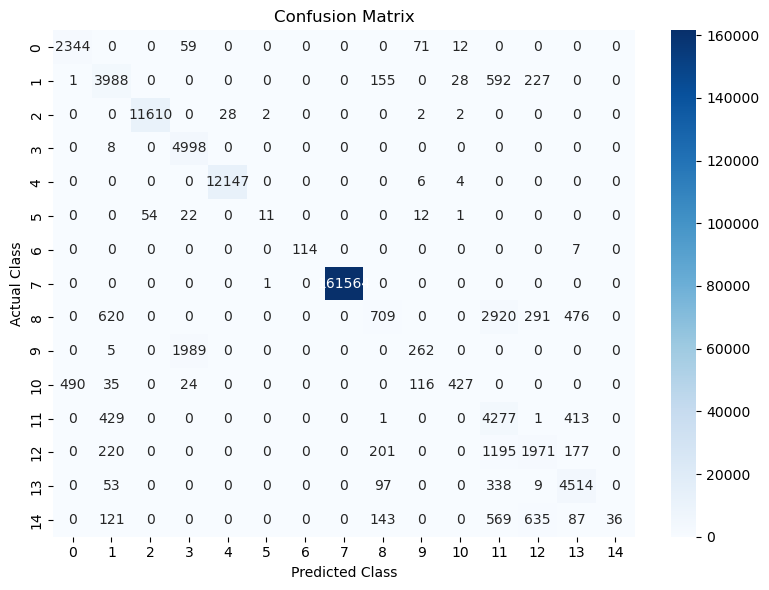

In [20]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.tight_layout()
plt.show()

In [21]:
model.save("lstm_edge_model.h5")

In [ ]:
print("X_test_lstm shape:", X_test_lstm.shape)
print("y_test_np shape:", y_test_np.shape)
print("X_test_lstm dtype:", X_test_lstm.dtype)
print("y_test_np dtype:", y_test_np.dtype)

# CNN + LSTM Hybrid


In [10]:
timesteps = 10
total_features = X_train_fnn.shape[1]

remainder = total_features % timesteps  # 6
padding_size = timesteps - remainder  # 4

num_features = (total_features + padding_size) // timesteps  # 50 // 10 = 5

input_shape = (timesteps, num_features)



# --- Step 1: Convert DataFrames to NumPy Arrays ---
X_train_hybrid = X_train_fnn.to_numpy()
y_train_hybrid = y_train_fnn.to_numpy().reshape(-1, 1)

X_val_hybrid = X_val_fnn.to_numpy()
y_val_hybrid = y_val_fnn.to_numpy().reshape(-1, 1)

X_test_hybrid = X_test_fnn.to_numpy()
y_test_hybrid = y_test_fnn.to_numpy().reshape(-1, 1)

# --- Step 2: Scale Features ---
scaler = MinMaxScaler()
X_train_scaled_hybrid = scaler.fit_transform(X_train_hybrid)
X_val_scaled_hybrid = scaler.transform(X_val_hybrid)  # use transform only on val
X_test_scaled_hybrid = scaler.transform(X_test_hybrid)

#padding so that its evenly divided

X_train_padded = np.pad(
    X_train_scaled_hybrid,
    pad_width=((0, 0), (0, padding_size)),
    mode='constant',
    constant_values=0
)
X_val_padded = np.pad(
    X_val_scaled_hybrid,
    pad_width=((0, 0), (0, padding_size)),
    mode='constant',
    constant_values=0
)

X_test_padded = np.pad(
    X_test_scaled_hybrid,
    pad_width=((0, 0), (0, padding_size)),
    mode='constant',
    constant_values=0
)


X_train_hybrid = X_train_padded.reshape(-1, timesteps, num_features)
X_val_hybrid = X_val_padded.reshape(-1, timesteps, num_features)
X_test_hybrid = X_test_padded.reshape(-1, timesteps, num_features)

y_train_hybrid = to_categorical(y_train_fnn)
y_val_hybrid = to_categorical(y_val_fnn)
y_test_hybrid = to_categorical(y_test_fnn)



In [ ]:
num_classes = y_train_lstm.shape[1]

def cnn_lstm_gru_model(input_shape):
    model = Sequential([
        Conv1D(45, 3, padding='same', input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(2),
        Dropout(0.2),

        Conv1D(64, 3, padding='same'),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(2),
        Dropout(0.2),

        LSTM(24, return_sequences=False),

#         Dense(16, activation='relu',kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
model = cnn_lstm_gru_model(input_shape)
model.summary()

In [ ]:
train_start_time_hybrid = time.time()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train the model
history = model.fit(
    X_train_hybrid,
    y_train_hybrid,
    validation_data=(X_val_hybrid, y_val_hybrid),
    epochs=3,
    batch_size=32,
    callbacks=[early_stop],
    shuffle=True,
    class_weight=None,
)
# Record the ending time
train_end_time_hybrid = time.time()


# Evaluate the model
loss, accuracy = model.evaluate(X_test_hybrid, y_test_hybrid, batch_size=32)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate and print the training time
train_time_hybrid = train_end_time_hybrid - train_start_time_hybrid
print(f"Training time: {train_time_hybrid:.2f} seconds")


In [ ]:
# Plot the training and validation accuracy over the epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:

# Plot the training and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
#predictions using trained model
y_pred = model.predict(X_test_hybrid)
y_pred_labels = (y_pred > 0.5).astype(int)  # Convert to 0 or 1

In [ ]:
print(classification_report(y_test_hybrid, y_pred_labels))
print(confusion_matrix(y_test_hybrid, y_pred_labels))

In [ ]:
model.save("cnn_lstm_hybrid_model.h5")